# SVM results and predictions

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as plt 
from numpy import loadtxt
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from pickle import load

# importing sys
import sys
  
# adding Folder_2 to the system path
sys.path.insert(0, '../../bioacoustics/3_classifier')
from model.svm_model import SVM_model


In [4]:
def read_preds(pred_file):
    preds = loadtxt(pred_file, dtype= str, delimiter='\n', unpack=False)
    print(len(pd.Series(preds)))
    return preds

def read_pred_probs(pred_file):
    pred_prob = pd.read_csv(pred_file)
    return pred_prob.apply(lambda x : x.max(), axis=1)

def read_y_test(y_test_file):
    y_test = pd.read_csv(y_test_file)
    print(y_test.shape)
    return y_test

def get_confusion_matrix(y_test,preds):
    labels=['background','chimpanze']
    cm = confusion_matrix(y_test,preds)

    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.show()
    
def get_classification_report(y_test, preds):
    cr = classification_report(y_test, preds , output_dict=True)
    return pd.DataFrame(cr).transpose()

def read_svm_results(path):
    svm_all_preds = read_preds(path + '/_predictions.txt')
    svm_all_y_test = read_y_test(path + '/_y_test.csv')
    return svm_all_preds, svm_all_y_test 

def normalize(x_test, svm_dir):
    scaler = load(open(svm_dir + 'scaler/scaler.pkl', 'rb'))
    x_test_scaled = scaler.transform(x_test)
    return x_test_scaled


def read_file(file, dim):
    df = pd.read_csv(file)
    x = df.iloc[:, dim[0]:dim[1]]
    y = df['label_1']
    return x, y 


def filter_features(data, file, numfeat = 50):
    df = pd.read_csv(file)
    indices = list(df.sort_values(by=['feature_importances'], ascending=False).index[0:numfeat])
    return data[:, indices]


def read_files(file_path, dim, feature_file):
    files = glob.glob(file_path)
    print(files)
    for i in range(len(files)):
        if i == 0:
            x, y = read_file(files[i], dim)
        else:
            temp_x, temp_y = read_file(files[i], dim)
            x = pd.concat([x, temp_x], sort=False)
            y = pd.concat([y, temp_y], sort=False)
    
    
    x = filter_features(x.to_numpy(), feature_file)
    return x, y


def run_svm(x_test, y_test, model_path, output_dir):
    s = SVM_model()
    s.predict_model(x_test, model_path, dl_model=False)
    s.save_results(y_test, output_dir)

## Scenario 1: Sanctuary only 

### Step 1: Plot test results

In [5]:
svm_dir = '../svm-model/sanctuary/'
preds, targets = read_svm_results(svm_dir)

18414
(18414, 1)


[[13750  1081]
 [  247  3336]]


/tmp/ipykernel_108296/3485394455.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/tmp/ipykernel_108296/3485394455.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


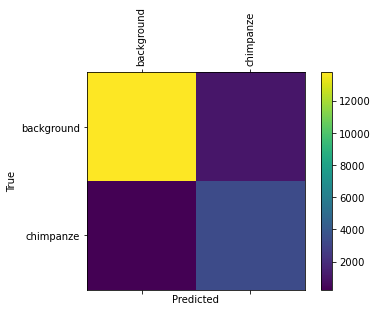

In [6]:
get_confusion_matrix(targets,preds)

In [7]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.982353,0.927112,0.953934,14831.000000
chimpanze,0.755264,0.931063,0.834000,3583.000000
accuracy,0.927881,0.927881,0.927881,0.927881
macro avg,0.868809,0.929088,0.893967,18414.000000
weighted avg,0.938166,0.927881,0.930597,18414.000000


### Step 2: Predict Sanaga sanctuary

#### Apply svm

In [6]:
train_path = '/home/jelle/Repositories/animalsounds/data/features/features_v7/features_sanct/*'
test_path = '/home/jelle/Repositories/animalsounds/data/features/test/sanaga/*'
output_dir = svm_dir + 'predictions/'

feature_file = svm_dir + 'feature_importances.csv'
model_path = svm_dir + 'sanctuary_svm_model.sav'

dim = [5, -1]

x_train, y_train = read_files(train_path, dim, feature_file)
x_test, y_test = read_files(test_path, dim, feature_file)

x_test = normalize(x_test, svm_dir)

run_svm(x_test, y_test, model_path, output_dir)

['/home/jelle/Repositories/animalsounds/data/features/features_v7/features_sanct/chimps_sanc_24000.csv', '/home/jelle/Repositories/animalsounds/data/features/features_v7/features_sanct/bg_sanc_chimp_24000.csv']
['/home/jelle/Repositories/animalsounds/data/features/test/sanaga/test_bg_24000.csv', '/home/jelle/Repositories/animalsounds/data/features/test/sanaga/test_chimp_24000.csv']


/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jelle/anaconda3/envs/animal-sounds/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.24.1 when using ver

prediction is done!


In [7]:
preds, targets = read_svm_results(svm_dir + 'predictions/')

112168
(112168, 1)


In [8]:
import numpy as np
targets[targets == 'chimp'] = 'chimpanze'
np.unique(targets)

array(['background', 'chimpanze'], dtype=object)

[[54560 12325]
 [ 4373 40910]]


/tmp/ipykernel_99456/3485394455.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/tmp/ipykernel_99456/3485394455.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


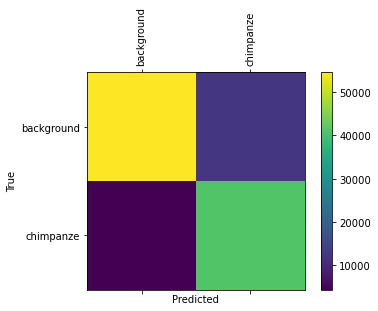

In [9]:
get_confusion_matrix(targets,preds)

In [10]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.925797,0.815728,0.867284,66885.000000
chimpanze,0.768479,0.903430,0.830508,45283.000000
accuracy,0.851134,0.851134,0.851134,0.851134
macro avg,0.847138,0.859579,0.848896,112168.000000
weighted avg,0.862287,0.851134,0.852438,112168.000000


## Scenario 2: Sanctuary + Synthetic

### Step 1: Plot Test results

In [4]:
preds_file = (folder_all + '_predictions.txt')
labels_file = (folder_all + '_y_test.csv')
preds, targets = read_svm_results(preds_file, labels_file)

51593
(51593, 1)


[[32033  2227]
 [ 3087 14246]]


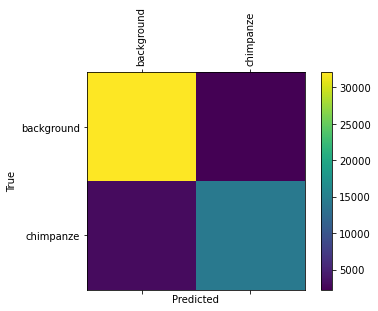

In [5]:
get_confusion_matrix(targets,preds)

In [6]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.912101,0.934997,0.923407,34260.000000
chimpanze,0.864809,0.821900,0.842809,17333.000000
accuracy,0.897002,0.897002,0.897002,0.897002
macro avg,0.888455,0.878449,0.883108,51593.000000
weighted avg,0.896213,0.897002,0.896330,51593.000000


### Step 2: Prediction Sanaga test set

In [8]:
train_path = '/home/jelle/Repositories/animalsounds/data/features/features_v7/features_sanctsynth/*'
test_path = '/home/jelle/Repositories/animalsounds/data/features/test/sanaga/*'
output_dir = '/home/jelle/Repositories/animal-sounds/data/svm_results/prediction_results/all/'

feature_file = '../../data/svm_results/training_all/feature_importances.csv'
model_folder = '../../data/svm_results/training_all/_acoustic_model.sav'

dim = [5, -1]

x_train, y_train = read_files(train_path, dim, feature_file)
x_test, y_test = read_files(test_path, dim, feature_file)

x_train, x_test = normalize(x_train, x_test)

run_svm(x_train, y_train, x_test, y_test, output_dir, model_folder)

['/home/jelle/Repositories/animalsounds/data/features/features_v7/features_sanctsynth/chimps_sanc_24000.csv', '/home/jelle/Repositories/animalsounds/data/features/features_v7/features_sanctsynth/chimps_synt_jungle_24000.csv', '/home/jelle/Repositories/animalsounds/data/features/features_v7/features_sanctsynth/bg_synth_24000.csv', '/home/jelle/Repositories/animalsounds/data/features/features_v7/features_sanctsynth/bg_sanc_chimp_24000.csv']
['/home/jelle/Repositories/animalsounds/data/features/test/sanaga/test_bg_24000.csv', '/home/jelle/Repositories/animalsounds/data/features/test/sanaga/test_chimp_24000.csv']


/home/jelle/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVC from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/jelle/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


prediction is done!


In [9]:
preds_file = ('../../data/svm_results/prediction_results/all/_predictions.txt')
labels_file = ('../../data/svm_results/prediction_results/all/_y_test.csv')
preds, targets = read_svm_results(preds_file, labels_file)

112168
(112168, 1)


In [11]:
import numpy as np
targets[targets == 'chimp'] = 'chimpanze'
np.unique(targets)

array(['background', 'chimpanze'], dtype=object)

[[40261 26624]
 [ 1624 43659]]


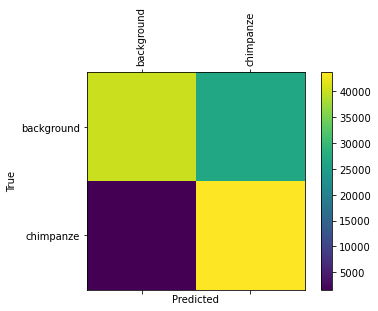

In [12]:
get_confusion_matrix(targets,preds)

In [13]:
get_classification_report(targets,preds)

,precision,recall,f1-score,support
background,0.961227,0.601944,0.740296,66885.000000
chimpanze,0.621189,0.964137,0.755568,45283.000000
accuracy,0.748163,0.748163,0.748163,0.748163
macro avg,0.791208,0.783040,0.747932,112168.000000
weighted avg,0.823951,0.748163,0.746462,112168.000000
